In [1]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import date

In [4]:
import scipy.stats as stats

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

In [14]:
# Calculate the date 1 year ago from the last data point in the database
for row in session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1):
    print(dt.datetime.strptime(row.date, '%Y-%m-%d').date())
    
Latest_date = dt.datetime.strptime(row.date, '%Y-%m-%d').date()
Date_12MonthsBack = Latest_date - dt.timedelta(days=366)

print(Date_12MonthsBack)

2017-08-23
2016-08-22


In [15]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > Date_12MonthsBack).\
    order_by(Measurement.date).all()



In [16]:

# Save the query results as a Pandas DataFrame and set the index to the date column

measurement_df = pd.DataFrame(results,columns=['date','precipitation'])
measurement_df.set_index('date',inplace=True)

# Sort the dataframe by date
measurement_df.sort_index(inplace=True)


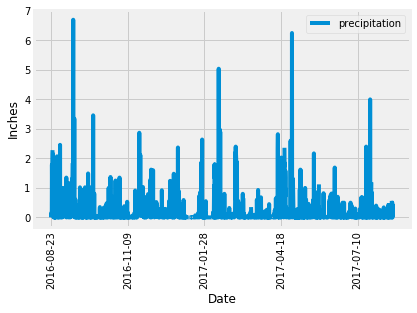

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

measurement_df.plot(rot=90);
plt.xlabel("Date");
plt.ylabel("Inches");
plt.savefig('Images/precipitation.png')

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
Station_count = session.query(Station.id).count()
print(f'Number of station in the dataset are = {Station_count}')


Number of station in the dataset are = 9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stmt = session.query(Measurement.station, func.count('*').\
            label('Observation_count')).\
            group_by(Measurement.station).\
            order_by('Observation_count').subquery()

print("Station name arranged by descending order of row counts")

print("########################################################")
for u, count in session.query(Station, stmt.c.Observation_count).\
                     outerjoin(stmt, Station.station == stmt.c.station).order_by(stmt.c.Observation_count.desc()):
                
                print(f'Station Id = {u.station}, Station Name is {u.name}, and row count is {count}')
print("########################################################")
print("Station Name - WAIHEE with ID = USC00519281 is most active station" )

Station name arranged by descending order of row counts
########################################################
Station Id = USC00519281, Station Name is WAIHEE 837.5, HI US, and row count is 2772
Station Id = USC00519397, Station Name is WAIKIKI 717.2, HI US, and row count is 2724
Station Id = USC00513117, Station Name is KANEOHE 838.1, HI US, and row count is 2709
Station Id = USC00519523, Station Name is WAIMANALO EXPERIMENTAL FARM, HI US, and row count is 2669
Station Id = USC00516128, Station Name is MANOA LYON ARBO 785.2, HI US, and row count is 2612
Station Id = USC00514830, Station Name is KUALOA RANCH HEADQUARTERS 886.9, HI US, and row count is 2202
Station Id = USC00511918, Station Name is HONOLULU OBSERVATORY 702.2, HI US, and row count is 1979
Station Id = USC00517948, Station Name is PEARL CITY, HI US, and row count is 1372
Station Id = USC00518838, Station Name is UPPER WAHIAWA 874.3, HI US, and row count is 511
########################################################
St

In [21]:
# Choose the station with the highest number of temperature observations.

most_active_station =  session.query(Station, stmt.c.Observation_count).\
                     outerjoin(stmt, Station.station == stmt.c.station).order_by(stmt.c.Observation_count.desc()).first()

print(most_active_station.station.station)

USC00519281


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

search_station  = most_active_station.station.station

sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

# YOUR CODE HERE
active_station_data = session.query(*sel).\
                            filter(Measurement.station == search_station)


for row in active_station_data:
    print(row)

('USC00519281', 54.0, 85.0, 71.66378066378067)


In [23]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

Last12Mnths_activeStation = session.query(Measurement.tobs).\
    filter(Measurement.date > Date_12MonthsBack).\
    filter(Measurement.station == search_station).\
    order_by(Measurement.tobs).all()

activestation_df = pd.DataFrame(Last12Mnths_activeStation,columns=['Temperature'])

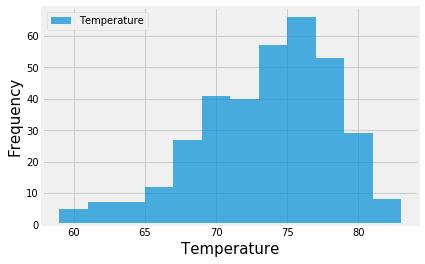

In [24]:
ax = activestation_df.plot.hist(bins=12, alpha = 0.7)
plt.xlabel("Temperature", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.savefig("Images/station-histogram.png")
ax.legend()

## Bonus Challenge Assignment

## Temperature Analysis I

In [25]:
#Identify the average temperature in June at all stations across all available years in the dataset.
#Do the same for December temperature.

JuneResults = session.query(Measurement.tobs).\
                    filter(func.strftime("%m",Measurement.date) == '06').all()

DecResults = session.query(Measurement.tobs).\
                    filter(func.strftime("%m",Measurement.date) == '12').all()

Ttest_June_df = pd.DataFrame(JuneResults,columns=['Observation'])
Ttest_Dec_df = pd.DataFrame(DecResults,columns=['Observation'])

In [26]:
print("Unpaired T-Test will be used since the Juneresults and Decresults are 2 Independent groups")
print(Ttest_June_df["Observation"].mean())
print(Ttest_Dec_df["Observation"].mean())

Unpaired T-Test will be used since the Juneresults and Decresults are 2 Independent groups
74.94411764705882
71.04152933421226


In [27]:
# H0: The difference between the mean temperatures of June and December is equal to zero
# H1: The difference between the mean temperatures of June and December is NOT equal to zero

stats.ttest_ind(Ttest_June_df["Observation"], Ttest_Dec_df["Observation"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

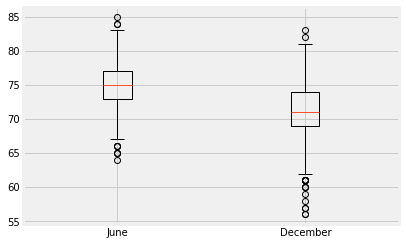

In [28]:
box_data = [Ttest_June_df["Observation"],Ttest_Dec_df["Observation"]]
plt.boxplot(box_data,labels=['June', 'December']);

In [29]:
print("The significant difference between the mean temperatures of June and December and the difference is not zero")

The significant difference between the mean temperatures of June and December and the difference is not zero


## Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = dt.datetime.strptime("2017-01-01", '%Y-%m-%d').date()
trip_end_date =  dt.datetime.strptime("2017-01-07", '%Y-%m-%d').date()


Previous_year_start_date = trip_start_date - dt.timedelta(days=366)
Previous_year_end_date = trip_end_date - dt.timedelta(days=366)

results= calc_temps(Previous_year_start_date, Previous_year_end_date)
trip_df = pd.DataFrame(results,columns=['Tmin','Tavg', 'Tmax'])



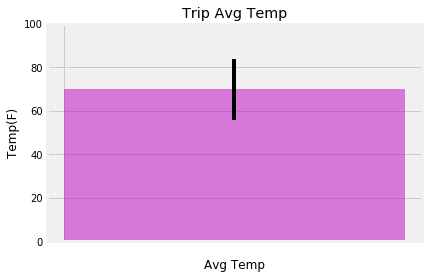

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(" ",trip_df["Tavg"],yerr=(trip_df["Tmax"] - trip_df["Tmin"]),color='m',alpha=.5,align='edge')
plt.ylim(0,100);
plt.xlabel('Avg Temp')
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.savefig("Images/temperature.png")

### Daily Rainfall Average

In [33]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sql = [Station.station, Station.name, func.sum(Measurement.tobs), Station.latitude, Station.longitude, Station.elevation]

results = session.query(*sql).\
                 filter(Measurement.date >= Previous_year_start_date).filter(Measurement.date <= Previous_year_end_date).\
                group_by(Measurement.station).\
                order_by(func.sum(Measurement.tobs).desc()).all()



In [34]:
pd.DataFrame(results,columns=['Station','Name', 'Total_Rainfall', 'Latitude', 'Longitude', 'Elevation'])

,Station,Name,Total_Rainfall,Latitude,Longitude,Elevation
0,USC00519397,"WAIKIKI 717.2, HI US",4662.0,21.2716,-157.8168,3.0
1,USC00519397,"WAIKIKI 717.2, HI US",4482.0,21.2716,-157.8168,3.0
2,USC00519397,"WAIKIKI 717.2, HI US",4392.0,21.2716,-157.8168,3.0
3,USC00519397,"WAIKIKI 717.2, HI US",4230.0,21.2716,-157.8168,3.0
4,USC00519397,"WAIKIKI 717.2, HI US",4176.0,21.2716,-157.8168,3.0
5,USC00519397,"WAIKIKI 717.2, HI US",3807.0,21.2716,-157.8168,3.0
6,USC00519397,"WAIKIKI 717.2, HI US",684.0,21.2716,-157.8168,3.0


### Shorter way to calculate daily normals

In [35]:
### calculate the daily normals for your trip 
##shorter way to calculaate daily normals by using group by clause in the query

sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs),  Measurement.date]
results = session.query(*sel).\
        filter(Measurement.date >= Previous_year_start_date).filter(Measurement.date <= Previous_year_end_date).\
            group_by(func.strftime("%m-%d", Measurement.date)).\
            order_by(func.strftime("%m-%d", Measurement.date)).all()

In [36]:
Trip_df = pd.DataFrame(results,columns=['Min','Avg', 'Max', 'Date'])
Trip_df.set_index('Date', inplace=True)
Trip_df

,Min,Avg,Max
Date,,,
2016-01-01,62.0,68.166667,74.0
2016-01-02,69.0,71.833333,73.0
2016-01-03,63.0,68.500000,75.0
2016-01-04,62.0,69.500000,76.0
2016-01-05,68.0,70.666667,75.0
2016-01-06,68.0,71.333333,74.0
2016-01-07,64.0,69.500000,76.0


Text(0, 0.5, 'Temperature')

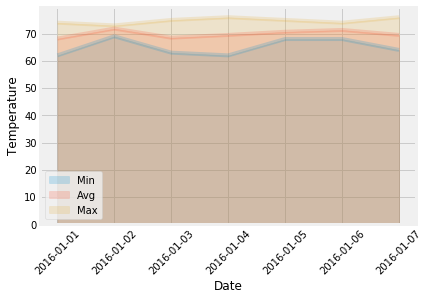

In [37]:
# Plot the daily normals as an area plot with `stacked=False`
Trip_df.plot(kind="area",stacked=False,rot=45,alpha=.2)
plt.xlabel("Date")
plt.ylabel("Temperature")

In [38]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
delta = Previous_year_start_date
normals_list = []
delta_list = []

# Loop through the list of %m-%d strings and calculate the normals for each date
while delta <= Previous_year_end_date:
    results = daily_normals(dt.datetime.strftime(delta,'%m-%d')) # Stip off the year and save a list of %m-%d strings
    normals_list.append(results[0])
    delta_list.append(dt.datetime.strftime(delta,'%Y-%m-%d'))
    delta = delta + dt.timedelta(days=1)
    

In [40]:
normals_list

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [41]:
delta_list

['2016-01-01',
 '2016-01-02',
 '2016-01-03',
 '2016-01-04',
 '2016-01-05',
 '2016-01-06',
 '2016-01-07']

In [42]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals_list,columns=["tmin","tavg","tmax"],index=[delta_list])
normals_df.index = normals_df.index.get_level_values(0)
normals_df

,tmin,tavg,tmax
2016-01-01,62.0,69.153846,77.0
2016-01-02,60.0,69.396226,77.0
2016-01-03,62.0,68.909091,77.0
2016-01-04,58.0,70.000000,76.0
2016-01-05,56.0,67.964286,76.0
2016-01-06,61.0,68.964912,76.0
2016-01-07,57.0,68.543860,76.0


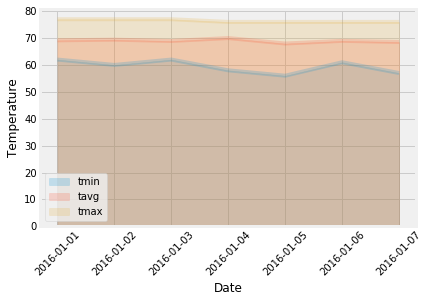

In [43]:
# Plot the daily normals as an area plot with `stacked=False`

normals_df.plot(kind="area",stacked=False,rot=45,alpha=.2)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.savefig("Images/daily-normals.png")